# Exploratory data analysis process
 
 In this notebook, I will analyse my Top Spotify Tracks from 2016 to 2022. The dataset contains information on 100 of my top songs for each year, including the track name and features, artist name,genre and popularity score. The data was extracted using the code found in this [repository](https://github.com/zpapagianni/Spotify_project/blob/main/notebooks/Extraction.ipynb). I will perform various analysis such as Exploratory Data Analysis, Data Cleaning, and Visualization to better understand my listening habits over the years. At the end we will implement a simple K-means clustering algorithm to divide the genres in this dataset into clusters based on the numerical audio features of each genre.
 

In [1]:
#Import libraries
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Language processing
import re
from wordcloud import WordCloud
from collections import Counter

# Import the library
import plotly.express as px

In [2]:
# Define colors for plots
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade features
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
]

## Load data
The dataset used in this notebook can be found in the [data folder](https://github.com/zpapagianni/Spotify_project/tree/main/data) of this repository. This notebook can also be adapted to use other datasets. To create your own dataset, you can use the Jupyter notebook found [here](https://github.com/zpapagianni/Spotify_project/blob/main/notebooks/Extraction.ipynb) and input your own Spotify playlists and API credentials.

In [3]:
# Load data from 'my_top_songs.csv' into a pandas DataFrame
songs = pd.read_csv('../data/my_top_songs.csv')
# display the top 5 rows of the DataFrame
songs.head(5)

,Unnamed: 0,artist_name,artist_pop,artist_genres,track_name,track_id,track_uri,popularity,danceability,energy,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,year
0,0,Alan Walker,82,['electro house'],Faded,1brwdYwjltrJo7WHpIvbYt,1brwdYwjltrJo7WHpIvbYt,0,0.589,0.651,...,0.166,90.011,audio_features,1brwdYwjltrJo7WHpIvbYt,spotify:track:1brwdYwjltrJo7WHpIvbYt,https://api.spotify.com/v1/tracks/1brwdYwjltrJ...,https://api.spotify.com/v1/audio-analysis/1brw...,212627,4,2016
1,1,Twenty One Pilots,81,"['modern rock', 'rock']",Ride,2Z8WuEywRWYTKe1NybPQEW,2Z8WuEywRWYTKe1NybPQEW,83,0.645,0.713,...,0.566,74.989,audio_features,2Z8WuEywRWYTKe1NybPQEW,spotify:track:2Z8WuEywRWYTKe1NybPQEW,https://api.spotify.com/v1/tracks/2Z8WuEywRWYT...,https://api.spotify.com/v1/audio-analysis/2Z8W...,214507,4,2016
2,2,New Beat Fund,41,[],No Type,4fxtYgcIOqjCq9Ix1pvrzn,4fxtYgcIOqjCq9Ix1pvrzn,47,0.619,0.622,...,0.210,136.978,audio_features,4fxtYgcIOqjCq9Ix1pvrzn,spotify:track:4fxtYgcIOqjCq9Ix1pvrzn,https://api.spotify.com/v1/tracks/4fxtYgcIOqjC...,https://api.spotify.com/v1/audio-analysis/4fxt...,213797,4,2016
3,3,The Strumbellas,58,"['canadian indie', 'folk-pop', 'pop rock', 'st...",Spirits,1mqbTByfUxLPeqN1YEw08a,1mqbTByfUxLPeqN1YEw08a,0,0.553,0.724,...,0.775,80.517,audio_features,1mqbTByfUxLPeqN1YEw08a,spotify:track:1mqbTByfUxLPeqN1YEw08a,https://api.spotify.com/v1/tracks/1mqbTByfUxLP...,https://api.spotify.com/v1/audio-analysis/1mqb...,203653,4,2016
4,4,Kygo,81,"['edm', 'pop', 'pop dance', 'tropical house']",Raging (feat. Kodaline),6DsFZITJMPnh8z5XewfVmL,6DsFZITJMPnh8z5XewfVmL,61,0.550,0.689,...,0.408,99.904,audio_features,6DsFZITJMPnh8z5XewfVmL,spotify:track:6DsFZITJMPnh8z5XewfVmL,https://api.spotify.com/v1/tracks/6DsFZITJMPnh...,https://api.spotify.com/v1/audio-analysis/6DsF...,224487,4,2016


## Data Preparation
Before we begin our analysis, we need to prepare our dataframe. We will start by dropping unnecessary columns such as `track_id`, `track_uri`, `type`, `id`, `uri`,`track_href`, and `analysis_url` as they are not relevant for this application. Next, we will convert the song duration from milliseconds to seconds for better readability and remove unwanted symbols from `artist_name` and `artist_genres`. 

In [4]:
# Specify columns to drop
columns_to_drop=['track_id', 'track_uri', 'type', 'id', 'uri','track_href','analysis_url']
# Drop columns
songs=songs.drop(columns_to_drop,axis=1)
# Convert duration from ms to sec
songs['duration_ms']=songs['duration_ms']*10**-3
# Drop NAs
songs=songs.dropna()
# Remove symbols from text
songs['artist_genres'] =songs['artist_genres'].apply( lambda x: re.sub(r"'", "", x, flags=re.MULTILINE))
# Convert artists names from object type to string
songs['artist_name'] =songs['artist_name'].apply(str)
# Remove symbols from text 
songs['artist_name'] =songs['artist_name'].apply( lambda x: re.sub(r'[^\w\s]', "", x, flags=re.MULTILINE))
# Rename columns
songs = songs.rename(columns={'Unnamed: 0': 'rank'})
songs.head(5)

,rank,artist_name,artist_pop,artist_genres,track_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
0,0,Alan Walker,82,[electro house],Faded,0,0.589,0.651,6,-5.097,1,0.0306,0.02910,0.000003,0.111,0.166,90.011,212.627,4,2016
1,1,Twenty One Pilots,81,"[modern rock, rock]",Ride,83,0.645,0.713,6,-5.355,1,0.0393,0.00835,0.000000,0.113,0.566,74.989,214.507,4,2016
2,2,New Beat Fund,41,[],No Type,47,0.619,0.622,5,-4.751,1,0.0328,0.00283,0.000133,0.108,0.210,136.978,213.797,4,2016
3,3,The Strumbellas,58,"[canadian indie, folk-pop, pop rock, stomp and...",Spirits,0,0.553,0.724,0,-3.695,1,0.0268,0.15900,0.000000,0.108,0.775,80.517,203.653,4,2016
4,4,Kygo,81,"[edm, pop, pop dance, tropical house]",Raging (feat. Kodaline),61,0.550,0.689,3,-7.760,0,0.0940,0.04980,0.000000,0.207,0.408,99.904,224.487,4,2016


## Data Visualisation
### Top gernes
In this section, we will explore the most common genres among the artists that I listened to the most over the years. We will do this by creating a wordcloud visualization based on the music genre of each artist. This will give us a clear understanding of the genres that I prefer and how they have evolved over the years.

Text(0.5, 1.0, 'Favorite artist gernes')

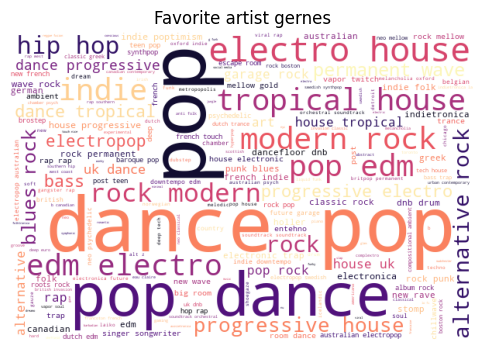

In [5]:
# Concatenate all genres in the 'artist_genres' column
top_gernes = ' '.join([word for word in songs['artist_genres']])
# Create a wordcloud object with specified width, height, random state, max font size, colormap, and background color
wordcloud_gernes = WordCloud(width=600,
                             height=400,
                             random_state=2,
                             max_font_size=100,
                             colormap='magma',
                             background_color="white").generate(top_gernes)


# Create a figure object and set its size and title
fig = plt.figure(figsize=(6, 6))
# Show image
plt.imshow(wordcloud_gernes)
plt.axis('off')
plt.title("Favorite artist gernes")

From the wordcloud above, it is clear that my favorite music genres over the years are pop, house, EDM, modern rock, and alternative rock. These are the genres that appear most frequently in the wordcloud. Next, we will create a visualization of my favorite genres for each year, to gain a more detailed understanding of how my preferences have evolved over time.

### Top gernes each year

In [6]:
# Group the dataframe by year and join the genres in each group
gernes = songs.groupby("year")["artist_genres"].apply(lambda x: Counter(" ".join(x).split(',')).most_common(5)).to_frame()

# Reset the index
gernes.reset_index(inplace=True)

# Explode the genres column to separate rows for each genre
gernes=gernes.explode('artist_genres')

# Split the genres and count columns from the exploded column
gernes[['genres','count']] = pd.DataFrame(gernes['artist_genres'].tolist(), index= gernes.index)

# Drop the exploded column
gernes=gernes.drop(['artist_genres'],axis=1)

In [7]:
def get_label_rotation(angle, offset):
    """
    Given an angle and an offset, calculates the rotation of the label
    and its alignment.

    Parameters:
    angle: float
        Angle of the bar in radians.
    offset: float
        Additional offset to add to the angle.

    Returns:
    rotation: float
        Rotation of the label in degrees.
    alignment: str
        Alignment of the label, can be "left" or "right".
    """
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    """
    Add labels to bars in a bar chart.

    Parameters:
    angles: list         of angles for each bar.
    values: list         of values for each bar.
    labels: list
        List of labels for each bar.
    offset: float
        Additional offset to add to the angle.
    ax: matplotlib axis object
        Axis where the chart is plotted.
    """

    # This is the space between the end of the bar and the label
    padding = 4

    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle

        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor"
        )

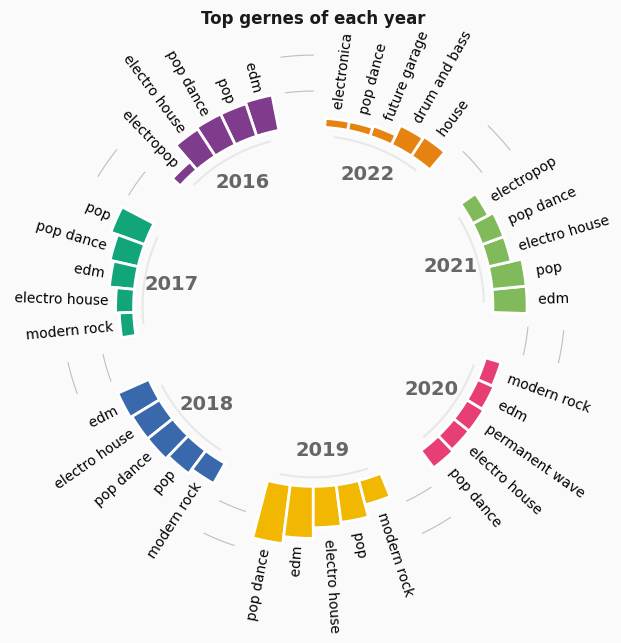

In [9]:
# Get values,labels and year labels
VALUES = gernes["count"].values
LABELS = gernes["genres"].values
GROUP = gernes["year"].values

#Add three empty bars to the end of each group
PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# Obtaining the right indexes is now a little more complicated
offset = 0
OFFSET = np.pi / 2
IDXS = []
GROUPS_SIZE = [5,5,5,5,5,5,5]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

    # Create a figure object and set size 
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={"projection": "polar"})
# Set background color to gray
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Set offset and axis limits
ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 50)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add title
fig.text(
    0.4,
    0.9,
    "Top gernes of each year",
    color=GREY10,
    fontsize=12,
    weight="bold"
)

# Create a list of colors for each bar, using the COLOR_SCALE variable
COLORS = [COLOR_SCALE[i] for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# Plot the bars on the polar axis
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS,
    edgecolor="white", linewidth=2
)

# Add labels to the bars using the add_labels function
add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# This iterates over the sizes of the groups adding reference
# lines and annotations.
offset = 0
for group, size in zip(np.unique(GROUP), GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color=GREY91)

    # Add text to indicate group
    ax.text(
        np.mean(x1), -20, group, color=GREY40, fontsize=14,
        fontweight="bold", ha="center", va="center"
    )

    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [80] * 50, color="#bebebe", lw=0.8)

    offset += size + PAD

The plot above illustrates my top 5 genres each year. It is clear that the most popular genre of music changes over time, but it is evident that I have always had a love for EDM and Electronic House. In 2016, EDM and Pop were my most popular genres, while in 2022, House and Drum and Bass have become the most popular. Additionally, it appears that I consistently listened to Pop Dance throughout the years, appearing in the top 5 most popular genres every year. There is also a variation in the popularity of genres within each year, with new genres like "permanent wave" and "future garage" being introduced.

From 2021 and onwards, my listening habits have shifted from Modern Rock to EDM, Electro House, House, and Drum and Bass. This shift may have happened because of the move I made to London in October 2019. At the start of 2020, the Covid-19 pandemic and lockdown measures caused my listening habits to remain unchanged. However, as restrictions were lifted in London in 2021, I started going to a lot of concerts and discovering new genres and artists that are popular in the UK. For example, I discovered Drum and Bass, a genre that emerged from the rave and jungle scenes in Britain during the early 1990s. Similarly, UK Garage (also known as UKG) is a genre of electronic music that originated in England in the early 1990s. The genre emerged from styles such as garage house, R&B, jungle, and dance-pop, which are all popular in London.  In recent years, there has been a resurgence of interest in house and techno music in London, with many clubs and venues hosting regular events and nights dedicated to these genres.

Research shows that London has a thriving electronic music scene and is considered a global center for electronic music, with numerous clubs, festivals, and events that attract electronic music enthusiasts from all over the world.
In addition, according to Spotify, EDM, Pop and Pop Dance are consistently among the top genres listened to globally. In the UK, House, Drum and Bass, and UK Garage are also popular genres,
 
My move to London, coupled with my love for electronic music, has undoubtedly influenced my listening habits and exposed me to new genres and artists.

### Top artists 
In this section, we will explore the most common artists that I listened to the most over the years. We will follow the same steps as above by creating a wordcloud visualization based on the name of each artist. 

Text(0.5, 1.0, 'Favorite artist gernes')

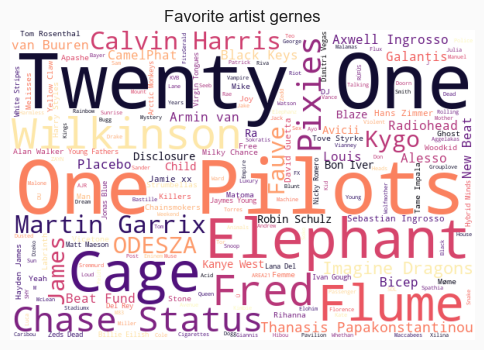

In [119]:
# Concatenate all artists names in the 'artist_names' column
artists = ' '.join([word for word in songs['artist_name']])
# Create wordcloud
wordcloud_gernes = WordCloud(width=600,
                             height=400,
                             random_state=2,
                             max_font_size=100,
                             colormap='magma',
                             background_color="white").generate(artists)


# Create a figure object and set its size and title
fig = plt.figure(figsize=(6, 6))
# showing image
plt.imshow(wordcloud_gernes)
plt.axis('off')
plt.title("Favorite artist gernes")

From the wordcloud above we observe that my favorite artists are Twenty One Pilots, Cage the Elephant, Fred again, Wilkinson, Flume and Chase and Status. In the section below, we visualise my top 20 favorite artists over the years using a bar plot.

In [38]:
#Find most loved artists over the years
artists =songs.loc[:,'artist_name']
# Use the Counter class to count the frequency of each word
word_counts = Counter(artists)
# Use the most_common() method to get the most common words
most_common_words = word_counts.most_common(20)
# Create dataframe
common_df = pd.DataFrame(most_common_words, columns=['Artist', 'Count'])

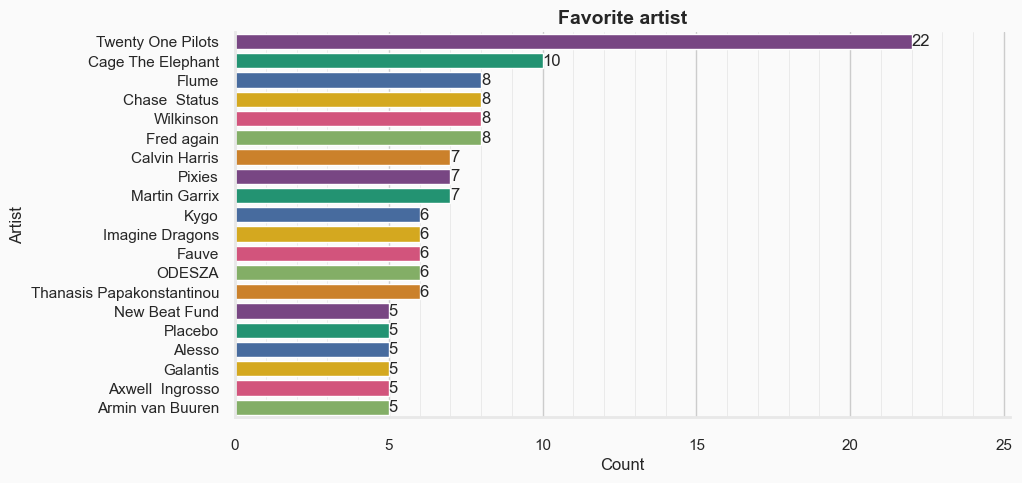

In [48]:
# plot 20 top artists
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (10, 5))
# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines every year
VLINES = np.arange(0, 25)
# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

art=sns.barplot(data=common_df, y='Artist', x='Count', palette=COLOR_SCALE,orient="h")
art.set_title("Top artists",fontdict= { 'fontsize': 14, 'fontweight':'bold'})
art.bar_label(ax.containers[0])
plt.show()

The bar plot illustrates the musical artists that I particularly enjoy listening to. As seen in the word cloud, it highlights my long-time favorites Twenty One Pilots and Cage the Elephant, who are both well-known bands in the modern rock genre. Additionally, the plot also represents my newly discovered electronic dance music (EDM) and house artists Flume and Fred again, who I discovered during my time living in London. Furthermore, the plot also shows my recent discoveries of drum and bass genre artists Chase and Status and Wilkinson, which I found my interest in London as well.

## Exploring audio features by year
Now that we have the data, let’s take a look at the features for each song. For this subpart specifically, we will be looking at the mean values of the features for the top 100 most popular songs, as well as all the dataset. To visualize this we can use a radar chart as below. The code below is:

Obtaining all the labels of the data, in our case the audio features, and taking their means. There are two variables: “features”, with the average values of the audio features for the top 100 songs and “features_all”, with the means for all the dataset.
Plotting the “features” and “features_all” on the same radar plot with different colors.

In [92]:
# ------- Mean of features
features= ['danceability','liveness','energy','valence','speechiness','acousticness','year']
song_feat=songs.loc[:,features]

summary_stats = song_feat.groupby(["year"]).mean().reset_index()
summary_stats

,year,danceability,liveness,energy,valence,speechiness,acousticness
0,2016,0.562790,0.185757,0.638416,0.373442,0.071155,0.262579
1,2017,0.567169,0.169356,0.644439,0.418400,0.076620,0.238498
2,2018,0.566530,0.217587,0.691392,0.477413,0.072232,0.178218
3,2019,0.554260,0.186681,0.703310,0.396293,0.065344,0.184734
4,2020,0.527760,0.192101,0.583556,0.327214,0.059749,0.302582
5,2021,0.585909,0.201386,0.736596,0.394502,0.077654,0.179647
6,2022,0.575220,0.168678,0.736020,0.312120,0.070012,0.146594


Text(0.4, 0.9, 'Audio Features')

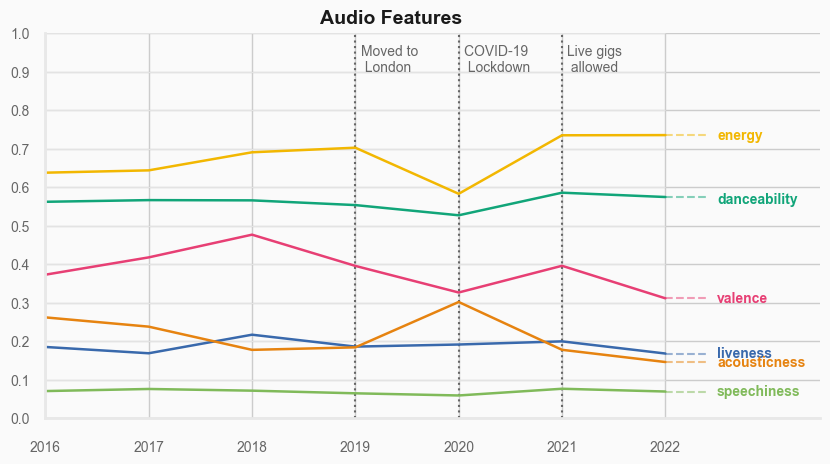

In [42]:
# Vertical lines every year
VLINES = np.arange(2016, 2023)

# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (10, 5))
# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 1.1 ,0.1), xmin=2016, xmax=2022, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2016, xmax=2022, color=GREY60, lw=0.8)

## Add vertical lines 
# Vertical like at x = 2019
ax.axvline(2019, color=GREY40, ls="dotted")
# Annotations indicating the meaning of the vertical line
ax.text(2019.05, 0.9, "Moved to \n London",
        fontsize=10, fontweight=500, color=GREY40, ha="left")

# Vertical like at x = 2020
ax.axvline(2020, color=GREY40, ls="dotted")
# Annotations indicating the meaning of the vertical line
ax.text(2020.05, 0.9, "COVID-19 \n Lockdown",
        fontsize=10, fontweight=500, color=GREY40, ha="left")

# Vertical like at x = 2021
ax.axvline(2021, color=GREY40, ls="dotted")
# Annotations indicating the meaning of the vertical line
ax.text(2021.05, 0.9, "Live events \n allowed",
        fontsize=10, fontweight=500, color=GREY40, ha="left")

# Adjust axes limits so annotations fit in the plot
ax.set_xlim(2016, 2023.5)
ax.set_ylim(0, 1)

# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.around(np.arange(0, 1.1 , 0.1),2)])
ax.set_yticklabels(
    [y for y in np.around(np.arange(0, 1.1 , 0.1),2)],
    fontsize=10,
    weight=500,
    color=GREY40)

ax.set_xticks([x for x in np.arange(2016, 2023)])
ax.set_xticklabels(
    [x for x in np.arange(2016, 2023)],
    fontsize=10,
    weight=500,
    color=GREY40)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Positions
LABEL_Y = [
    0,
    0.57,
    0.168,
    0.736,
    0.312,
    0.07,
    0.146]


# Create label lines
# starting year for the x-axis of the plot
x_start = 2022
# ending year for the x-axis of the plot
x_end = 2022.5
# padding added to the end of the x-axis
PAD = 0.1

# loop through each feature in the summary statistics
for idx, feature in enumerate(summary_stats):
     # skip the first index, which is the "year" column
    if idx!=0:
        color = COLOR_SCALE[idx]
        # plot the feature on the graph
        ax.plot("year", feature, color=color, lw=1.8, data=summary_stats)
        # feature name
        text = feature

        # Vertical start of line
        y_start = summary_stats[feature].values[-1]
        # Vertical end of line
        y_end = LABEL_Y[idx]

        # Add line based on three points
        ax.plot(
            [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD],
            [y_start, y_start, y_start],
            color=color,
            alpha=0.5,
            ls="dashed")

        # Add feature text
        ax.text(
            x_end,
            y_end,
            text,
            color=color,
            fontsize=10,
            weight="bold",
            va="center")

        # Add title
fig.text(
    0.4,
    0.9,
    "Audio Features",
    color=GREY10,
    fontsize=14,
    weight="bold")

The plot above illustrates my listening habits over the years, with specific focus on the audio features such as energy, valence,danceability,liveness accousticness and speechiness of the tracks. Overall we can observe that
the energy and danceability of the songs I am listening to is high as electronic and rock music tend to have fast tempos and strong beats that create a feeling of excitement and movement. The average value for energy seems to fluctuate around 0.7 and 0.65 for danceability. Those are considered high values, indicating that the songs I am listening to are likely upbeat and energetic. Valence and Acousticness are metrics used to describe the emotional and musical characteristics of a song respectively. Values less than 0.4 for valence and less than 0.3 for acousticness are considered low, indicating that the songs I generally listened to are sad or less acoustic respectively.

From 2016 to 2019, we can see that the energy of the songs I was listening to gradually increased, along with the valence and liveness. The acousticness started to decrease which may have been due to a shift in my music preferences towards more electronic and less acoustic music as we observed above.Overall,this may indicate that during this time, I was listening to more upbeat, positive, and lively music.

However, starting in 2019, we can see a shift in my listening habits. Specifically, the valence of the songs I was listening to began to decrease. This could be attributed to a number of factors, including my first heartbreak in 2019, and my move to London in October of that year.As I was experiencing a new environment and potentially a change in mood.

The valence continued to decrease in 2020, likely due to the impact of the Covid-19 pandemic which resulted in a majority of the year being spent in lockdown. This may reflect a more negative or introspective mood during this time. As a result, the energy of the songs I was listening to also decreased significantly. In addition, there was a significant increase in acousticness that could have been a result of a temporary change in your music preferences towards more acoustic music. Despite this, the danceability of the songs remained relatively steady.

In 2021, as restrictions were lifted in London and live events being allowed again. I was going to a lot of concerts and seeing a lot of new DJs, which brought me more positive and upbeat music. This likely contributed to a significant increase in the energy, valence, and danceability of the tracks I was listening to, as I was exposed to a wider variety of music and styles. The decrease in acousticness from 2020 to 2021 could be due to a shift in your music preferences towards more electronic and less acoustic music.

In 2022, we can observe that the energy and dancebility have remained the same with an average of 0.75 an 0.58 respectively. The continuation of the decrease in acousticness from 2021 to 2022 may be due to my recent interest in drum and bass and house music, which are both electronic genres that tend to have less acoustic features.However, as my mental health struggles may have led to a decrease in the valence of the songs I was listening to, reaching the same level as in 2020.

The speechiness has remained relatively steady over the years with very small fluctuations. Below we visualise the density of each feature by year.

<Figure size 500x300 with 0 Axes>

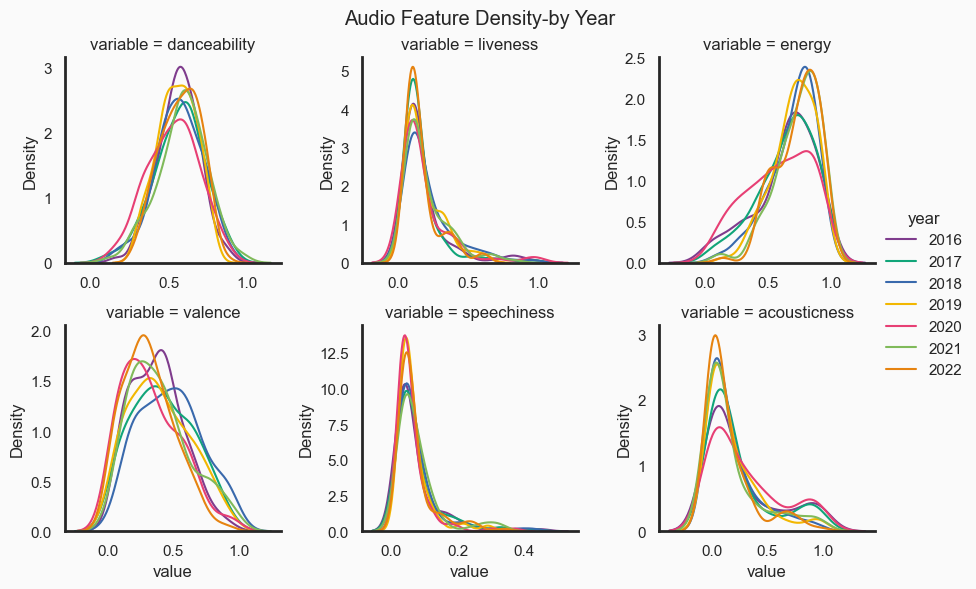

In [117]:
# recast into long format 
song_feat = song_feat.melt(id_vars=['year'], value_vars=features)
# Set figure size (width, height) in inches
plt.figure(figsize = ( 5 , 3 ))
sns.set_theme(style="white", rc={"axes.facecolor":(0, 0, 0, 0) , 'axes.linewidth':2, 'figure.facecolor':'"#fafafa"'})
g=sns.FacetGrid(data=song_feat, col='variable',hue="year", col_wrap=3, sharex=False, sharey=False,palette=COLOR_SCALE)
p1 = g.map(sns.kdeplot, 'value').add_legend()
p1.fig.suptitle('Audio Feature Density-by Year')
p1.fig.subplots_adjust(top=0.9)
plt.show()


## Features Correlation

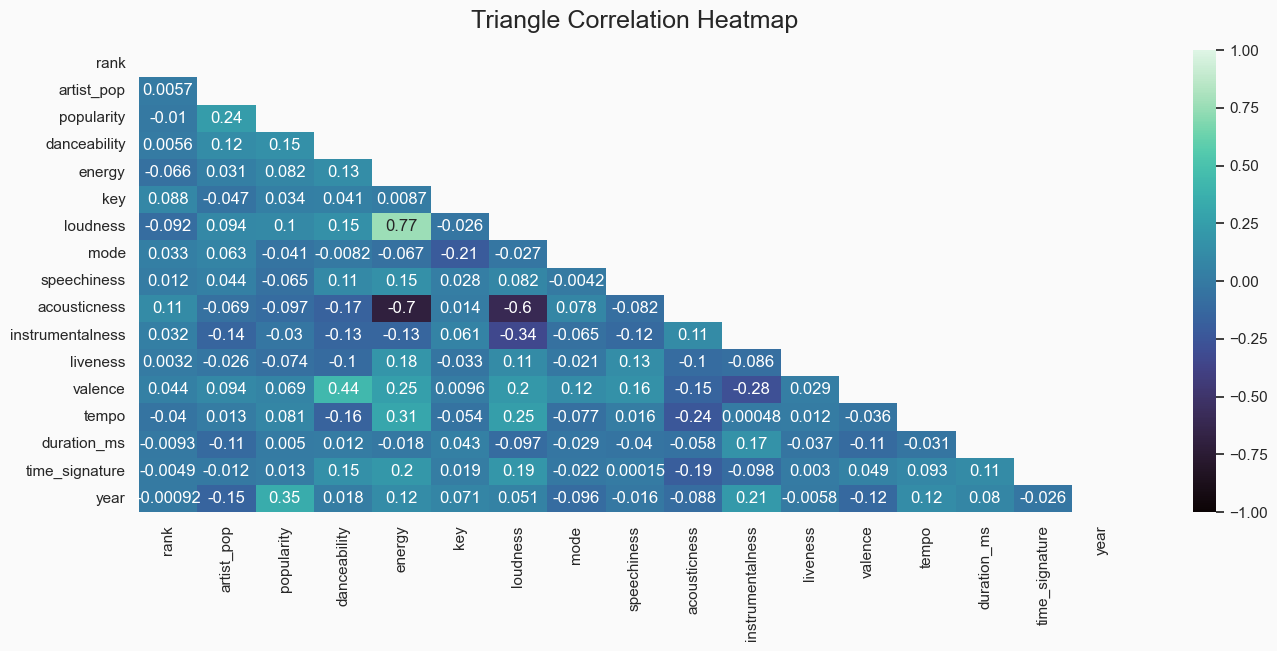

In [122]:
plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to Truemask = np.triu(np.ones_like(dataframe.corr(), dtype=np.bool))
mask = np.triu(np.ones_like(songs.corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(songs.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='mako')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

The heatmap above shows the correlation between various audio features of tracks. As per the Spotify algorithm, popularity of a track is determined by its recent streams. From the heatmap, it is clear that there is a negative correlation between acousticness and energy. Energy has a strong positive correlation with loudness and a negative correlation with acousticness. It also has a moderate correlation with valence and tempo. As expected, danceability has a moderate correlation with valence. Additionally, loudness has a negative correlation with both acousticness and instrumentalness. These observations can be made by analyzing the correlation matrix of the dataset.

## Tracks Tempo
Next we will visualise the distribution of the tracks tempo other the years. Tempo represents the overall estimated tempo of a track in beats per minute (BPM). In musical terminology, it is the speed or pace of a given piece and derives directly from the average beat duration. Below is a list of my mosy common electronic music genres and the tempos that are typically associated with each:

* Pop	100-130 BPM
* Rock	110-140 BPM
* Techno	120–125 BPM
* House	115–130 BPM
* Garage 130 BPM
* Electro	128 BPM
* Drum and Bass	174 BPM

Text(0.5, 0.98, 'Songs Tempo')

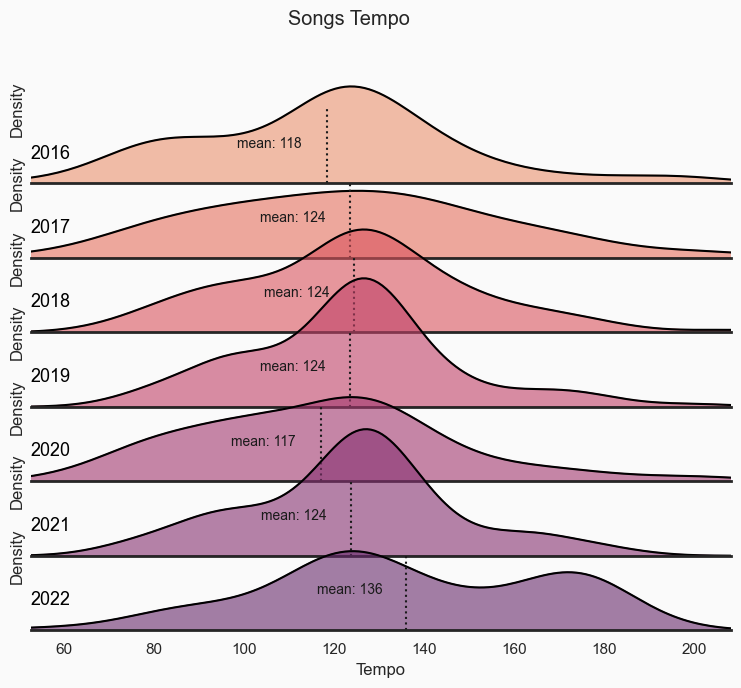

In [201]:
# Ridge plot of Tempo
# Initialize layout ----------------------------------------------
sns.set_theme(style="white", rc={"axes.facecolor":(0, 0, 0, 0) , 'axes.linewidth':2, 'figure.facecolor':'"#fafafa"'})
palette = sns.color_palette("flare", 7)

# create a grid with a row for each 'year'
g = sns.FacetGrid(songs, palette=palette, row="year", hue="year", height=1, aspect=8)

# map df - Kernel Density Plot of Tempo for each year
g.map_dataframe(sns.kdeplot, x="tempo", fill=True, alpha=0.6)
g.map_dataframe(sns.kdeplot, x="tempo", color='black')

# Add vertical lines for mean tempo on each plot
def vertical_mean(x, **kwargs):
    plt.axvline(x.mean(), ymin=0, ymax=0.5, color=GREY10, ls="dotted")
    tx = "mean: {:.0f}".format(x.mean())
    txkw = dict(size=10, color = GREY10)
    plt.text(x.mean()-20, 0.006, tx, **txkw)

g.map(vertical_mean, 'tempo',clip_on=False)

# function to draw labels
def label(x, color, label):
    ax = plt.gca() #get current axis
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
# iterate grid to plot labels
g.map(label, "year")

# adjust subplots to create overlap
g.fig.subplots_adjust(hspace=-.5)

# remove subplot titles
g.set_titles("")
# Add limits
g.set(xlim=(songs['tempo'].min(), songs['tempo'].max()), ylim=(0,0.025))
# remove yticks and set xlabel
g.set(yticks=[], xlabel="Tempo")
# remove left spine
g.despine(left=True)
# set title
plt.suptitle('Songs Tempo', y=0.98)

We can observe from the plot above that the mean tempo of the tracks I listen to didn't change significantly from 2016 to 2021. This correlates with the genres I am listening to such as rock and electronic music, which generally have a tempo range of 110 to 130 beats per minute (bpm). In 2020, we can observe that the tempo distribution is left skewed, while in 2021 it is more symmetric. However, in 2022 we observe a significant increase in the mean tempo, with a new peak around 160 bpm. This could be explained by my shift in music preferences, as I mentioned starting to listen to techno, and drum and bass, which are known to have higher tempos, typically ranging from 130 to 160 bpm. This could be the reason for the second peak at around 175 bpm in 2022.

## Duration

<Figure size 500x300 with 0 Axes>

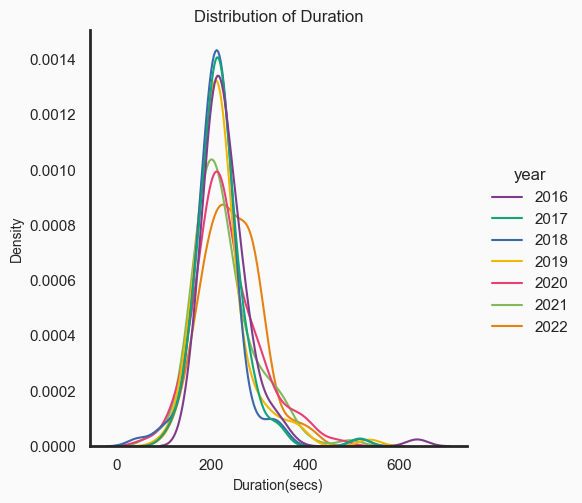

In [85]:
# Initialize layout ----------------------------------------------
# Set figure size (width, height) in inches
plt.figure(figsize = ( 5 , 3 ))
sns.set_theme(style="white", rc={"axes.facecolor":(0, 0, 0, 0) , 'axes.linewidth':2, 'figure.facecolor':'"#fafafa"'})
sns.displot(kind='kde',data=songs, x='duration_ms', hue='year',palette=COLOR_SCALE)
# Set label for x-axis
plt.xlabel( "Duration(secs)" , size = 10 )

# Set label for y-axis
plt.ylabel( "Density" , size = 10 )

# Set title for figure
plt.title( "Distribution of Duration" , size = 12 )

plt.show()

The distribution is maxing out at 200 secs (3.3 minutes). Additionally, it's worth noting that the distribution of song duration also shifts in 2022, with a slight increase in the mean length of tracks to around 220 seconds (3.6 minutes). This is consistent with the longer duration of many house and EDM tracks.

### Artist and Track Popularity 
Finally, we visualise the distribution of the artists and tracks popularity. The popularity has a value between 0 and 100, with 100 being the most popular. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. The artist's popularity is calculated from the popularity of all the artist's tracks.

In [66]:
# Create popularity dataframe to use for visualisation
popularity=songs.loc[:,['year','artist_pop','popularity']]
#Rename columns
popularity = popularity.rename(columns={'artist_pop': 'Artist', 'popularity': 'Track'})
# "Melt" the dataset to "long-form" or "tidy" representation
popularity=pd.melt(popularity, "year", var_name="popularity")
popularity.head(5)

,year,popularity,value
0,2016,Artist,82
1,2016,Artist,81
2,2016,Artist,41
3,2016,Artist,58
4,2016,Artist,81


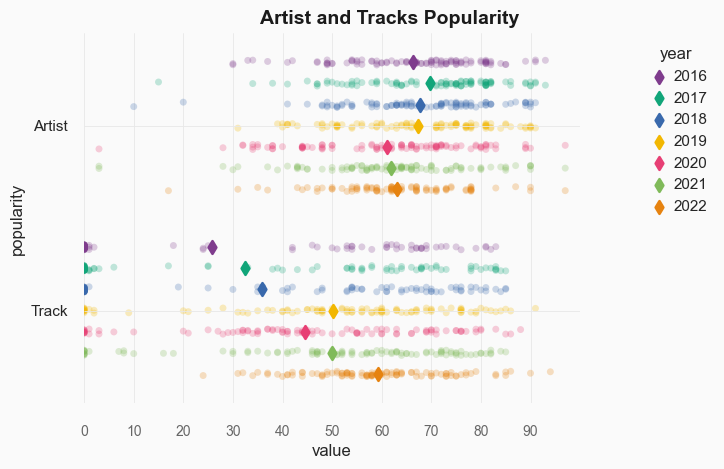

In [123]:
# Initialize layout ----------------------------------------------
sns.set_theme(style="white", rc={"axes.facecolor":(0, 0, 0, 0) , 'axes.linewidth':2, 'figure.facecolor':'"#fafafa"'})
palette = sns.color_palette("flare", 7)


# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

f.text(
    0.4,
    0.9,
    "Artist and Tracks Popularity",
    color=GREY10,
    fontsize=14,
    weight="bold"
)

# Vertical lines every year
VLINES = np.arange(0, 100,10)
# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 100), xmin=0, xmax=100, color=GREY91, lw=0.6)

# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(0, 100)

ax.set_xticks([x for x in np.arange(0, 100,10)])
ax.set_xticklabels(
    [x for x in np.arange(0, 100,10)],
    fontsize=10,
    weight=500,
    color=GREY40
)


# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")


# Show each observation with a scatterplot
sns.stripplot(
    data=popularity, x="value", y="popularity",hue="year", palette=COLOR_SCALE,
    dodge=True, alpha=.25, zorder=1, legend=False
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
point=sns.pointplot(
    data=popularity, x="value", y="popularity", hue="year",
    join=False, dodge=.8 - .8 / 7,  palette=COLOR_SCALE,
    markers="d", scale=.95, errorbar=None
)

# Improve the legend
sns.move_legend(
    ax, loc="upper left", frameon=False, columnspacing=1, handletextpad=0,bbox_to_anchor=(1.1, 1))


The popularity of tracks generally increases over time, which is to be expected as newer music is more likely to be streamed. As stated earlier, Spotify's algorithm for determining a track's popularity is based on recent streams. From the data, it appears that the popularity of the artists in the dataset ranges from 60 to 70. Overall, we can observe from the scatter plot that the data points are dispersed, indicating that I am listening to both popular and less popular artists. This could be interpreted as a diverse taste in music.

## Clustering Genres with K-Means
Here, the simple K-means clustering algorithm is used to divide the genres in this dataset into ten clusters based on the numerical audio features of each genre.

We create a pipeline object, which includes two steps: first, the data is scaled using the StandardScaler() method, and then KMeans clustering is applied with n_clusters=10. The pipeline object is then fitted to the data and used to predict the cluster for each observation in the dataset. The predicted clusters is then added to the songs dataframe as a new column called "cluster".

In [127]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create pipeline
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
# Select only the numerical columns 
X = songs.select_dtypes(np.number)
cluster_pipeline.fit(X)
songs['cluster'] = cluster_pipeline.predict(X)

We create another pipeline object, which includes two steps: first, the data is scaled using the StandardScaler() method, and then t-SNE dimensionality reduction is applied with n_components=2 and verbose=1.

The variable X that was created in previous code is used here as input to fit_transform method of tsne_pipeline to reduce the dimensions of the data. Then the reduced dimensions of the data is stored in a variable called genre_embedding. A new dataframe is created with columns 'x','y' and data is assigned as genre_embedding.The new dataframe is then associated with genres and cluster column from songs dataframe.

Finally, we create a 2D projection of the data that can be visualized. The resulting projection includes the 'artist_genres' and 'cluster' columns from the original songs dataframe, allowing the clusters and genres of each song to be compared in the visualization.

In [128]:
# Visualizing the Clusters with t-SNE

from sklearn.manifold import TSNE

#Create pipeline
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
# Fit data
genre_embedding = tsne_pipeline.fit_transform(X)
# Create reduced dataframe
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
# Add genres and cluster column from songs dataframe.
projection['genres'] = songs['artist_genres']
projection['cluster'] = songs['cluster']

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 699 samples in 0.001s...
[t-SNE] Computed neighbors for 699 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 699 / 699
[t-SNE] Mean sigma: 1.589162
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.091949
[t-SNE] KL divergence after 1000 iterations: 1.059746


In [129]:
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'],
     title="2D projection using t-SNE",template = "plotly_white")
fig.show()